### **Backtesting**

In [1]:
import numpy as np  # array operations
import pandas as pd  # time series management
import matplotlib.pyplot as plt  # standard plotting library
from pylab import plt
plt.style.use('ggplot')
# put all plots in the notebook itself
%matplotlib inline

## Retrieving Index Level Data
Remember from the [`Financial Data`](https://github.com/LucianoBritis/Python-for-Finance/blob/main/Financial%20Data.ipynb), how we retrieve **get_data_yahoo**. Now, we work with Adobe, Inc. stock prices.

In [2]:
df = pd.read_csv('./dataset/data.csv',
                   index_col=0, parse_dates=True).dropna()

In [3]:
symbol = 'ADBE'
data = pd.DataFrame(df[symbol]).dropna()

In [4]:
data.tail()

,ADBE
Date,
2022-09-19,296.059998
2022-09-20,291.059998
2022-09-21,286.299988
2022-09-22,287.059998
2022-09-23,284.559998


## Generating Trading Signals

We want to implement a **trading strategy based on simple moving averages (SMA)**. We work with two SMAs:

* short-term SMA over 42 days (SMA42)
* long-term SMA over 252 days (SMA252)

We distinguish two constellations:

* SMA42 > SMA252: buy signal, being **long** the market
* SMA42 < SMA252: sell signal, being **short** the market

In [5]:
data['SMA_42'] = data[symbol].rolling(window=42).mean()
data['SMA_252'] = data[symbol].rolling(window=252).mean()
data.dropna(inplace=True)  # drop rows with NaN values  

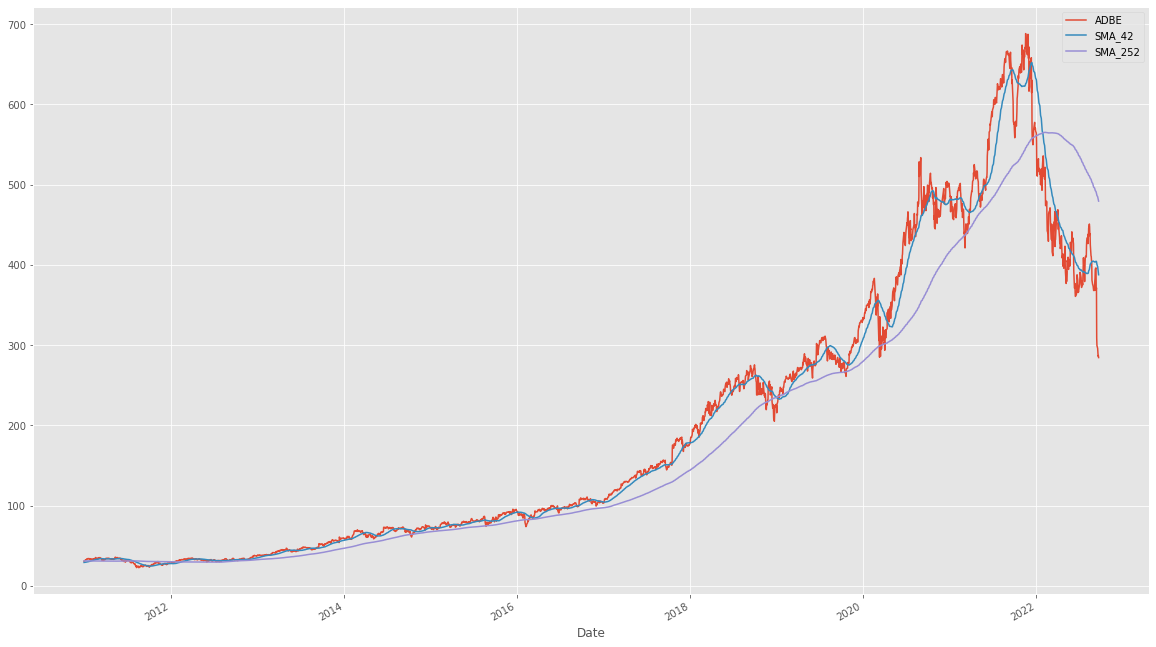

In [6]:
data[[symbol, 'SMA_42', 'SMA_252']].plot(figsize=(20, 12));

This need to be formalized for the calculations to come. 
- We represent **"being long the market" by 1** and **"being short the market" by -1**.

In [7]:
# vectorized evaluation of the trading condition/signal generation
data['position'] = np.where(data['SMA_42'] > data['SMA_252'], 1, -1)

Let us **visualize the positions** resulting from the signal. We start with a long position, do several re-positionings and end with a short position.

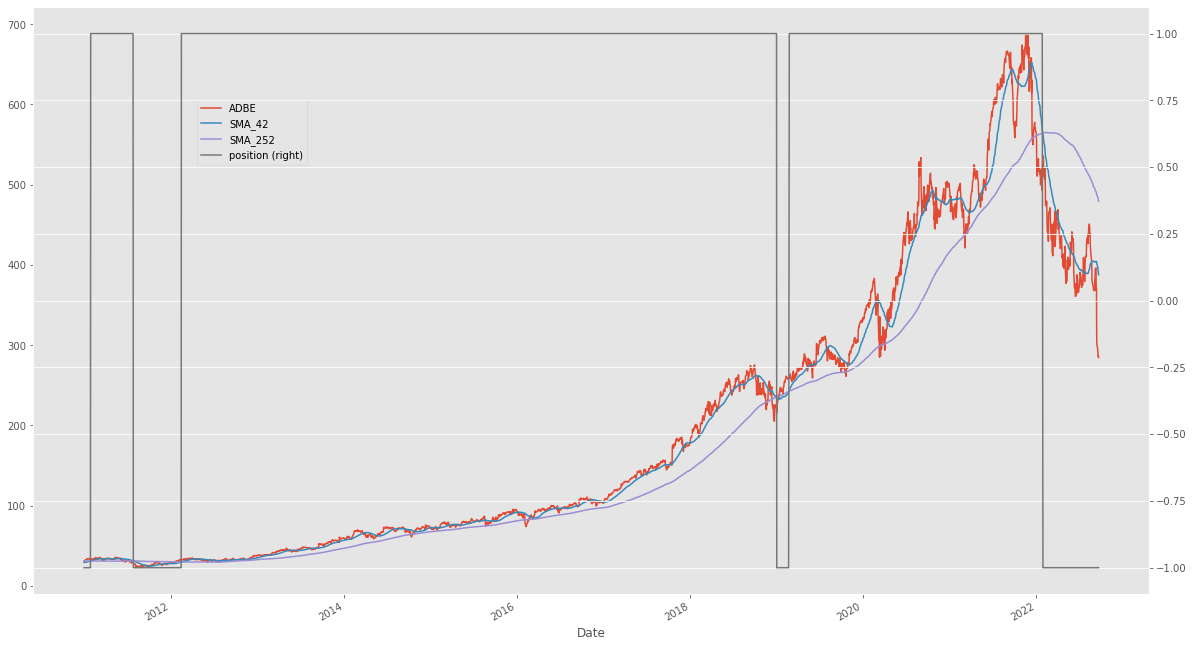

In [8]:
ax = data.plot(secondary_y='position', figsize=(20, 12))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

## Backtesting = Judging Performance

Let us calculate the **log returns** as in the first module. These are needed to judge the performance, i.e. to backtest, our SMA-based trading strategy. We call the column `market` since these are the _market returns_.

In [9]:
data['market'] = np.log(data[symbol]/data[symbol].shift(1))

Next, we can use the market returns to derive the **strategy returns** in vectorized fashion. Note the shift of the `position` column by one day, i.e. we have entered/maintained a position yesterday and and today's returns. It now becomes clear, why 1 represents a long position and -1 a short position: we get the market return when we are long and -1 times the market return when we are short. All this makes obviously a number of simplifying assumptions (e.g. no transaction costs).

In [10]:
# vectorized calculation of strategy returns
data['strategy'] = data['position'].shift(1) * data['market']

Next, let us calculate the **cumulative returns** of the market vs. the trading strategy. This is straightforward since we work with log returns. We first calculate the cumulative sums (`cumsum`) and the apply the exponential function (`np.exp`) to the respective time series.

In [11]:
data[['market','strategy']].cumsum().apply(np.exp).tail()

,market,strategy
Date,,
2022-09-19,9.618583,15.077473
2022-09-20,9.456140,15.336482
2022-09-21,9.301494,15.591466
2022-09-22,9.326186,15.550187
2022-09-23,9.244964,15.686803


And the **cumulative market vs. strategy returns** visualized. As the numbers and the plot suggest, the strategy in this case **outperforms** the market by a considerable margin.

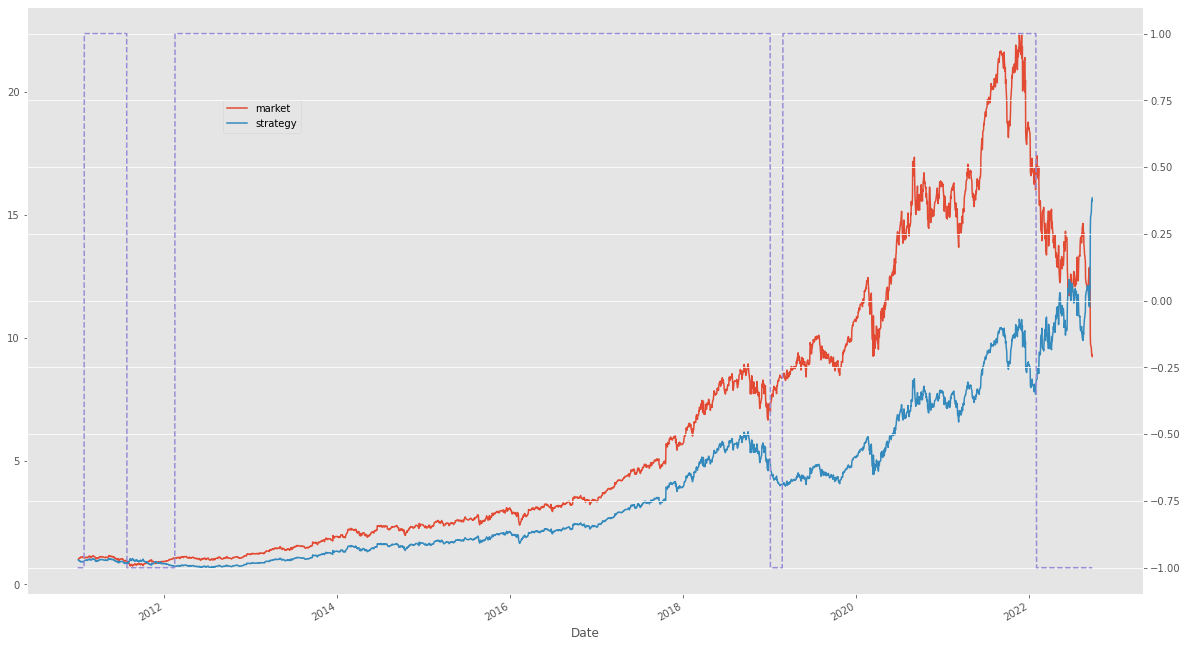

In [12]:
ax = data[['market', 'strategy']].cumsum().apply(np.exp).plot(figsize=(20, 12))
data['position'].plot(ax=ax, secondary_y='position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

## Risk and Return

Final consideration: what about the relation between **risk & return**? Let us quickly do the math. The **annualized return** of the strategy is obviously higher that from the market ...

In [13]:
arets = data[['market','strategy']].mean() * 252 # annualized returns
arets

market      0.189860
strategy    0.234997
dtype: float64

... while the **annualized volatility** is more or less the same. The higher returns do not lead to higher risk in this case.

In [14]:
astds = data[['market','strategy']].std() * 252 ** .5 # annualized volatility
astds

market      0.309535
strategy    0.309412
dtype: float64

## Optimization to identify the parameters

 - optimization procedure

In [15]:
from itertools import product

In [16]:
sma1 = range(20, 61, 4) # specifies the parameter values for SMA1.
sma2 = range(180, 281, 10)  # specifies the parameter values for SMA2.

In [17]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2): # combines all values for SMA1 with those for SMA2
    data = pd.DataFrame(data[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol]/data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns','Strategy']].sum())
    # Records the vectorized backtesting results in a DataFrame object.
    results = pd.concat([results, pd.DataFrame({ 
        'SMA1': SMA1, 
        'SMA2': SMA2,
        'MARKET': perf['Returns'],
        'STRATEGY': perf['Strategy'],
        'OUT': perf['Strategy'] - perf['Returns']},
        index=[0])], ignore_index=True) 

In [18]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      121 non-null    int64  
 1   SMA2      121 non-null    int64  
 2   MARKET    121 non-null    float64
 3   STRATEGY  121 non-null    float64
 4   OUT       121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


overview of the results, shows the five best performing parameter combinations of all those backtested.

In [19]:
results.sort_values('OUT', ascending=False).head()

,SMA1,SMA2,MARKET,STRATEGY,OUT
4,20,220,3.822163,6.995705,3.173542
7,20,250,1.616543,4.560345,2.943802
5,20,230,3.117782,5.848189,2.730407
8,20,260,1.162228,3.502853,2.340624
9,20,270,0.926755,3.243726,2.316972


A more rigorous approach would be to implement the optimization on one data set, the in-sample or training data set, and test it on another one, the out-of-sample or testing data set.

### Random Walk Hypothesis
 - The basic idea is that the market prices from yesterday and four more days back can be used to predict today’s market price. 

In [20]:
symbol = 'AOS'
data = pd.DataFrame(df[symbol])

In [21]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag) # defines a column name for the current lag value.
    data[col] = data[symbol].shift(lag) # creates the lagged version of the market prices for the current lag value.
    data.dropna(inplace=True)
    cols.append(col) # Collects the column names for later reference.

In [22]:
data.head(n=5)

,AOS,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-26,5.872433,5.936158,5.948626,6.015122,6.228462,6.193830
2010-01-27,6.097199,5.872433,5.936158,5.948626,6.015122,6.228462
2010-01-28,6.006734,6.097199,5.872433,5.936158,5.948626,6.015122
2010-01-29,5.926013,6.006734,6.097199,5.872433,5.936158,5.948626
2010-02-01,5.914878,5.926013,6.006734,6.097199,5.872433,5.936158


##  Linear OLS Regression

 - applies linear OLS regression to predict the direction of market move‐ments based on historical log returns.
 - To keep things simple, only two features are used. The first feature (lag_1) represents the log returns of the financial time series lagged by one day. The second feature (lag_2) lags the log returns by two days.

The Data
 - preparation of the data set. 

In [23]:
df = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                   index_col=0, parse_dates=True)

In [24]:
df.columns = [i.replace('=','') for i in df.columns]

In [25]:
symbol = 'EUR'
data = pd.DataFrame(df[symbol])

In [26]:
data['returns'] = np.log(data /data.shift(1))
data.dropna(inplace=True)

In [27]:
data['direction'] = np.sign(data.returns).astype(int)

In [28]:
data.head(n=2)

,EUR,returns,direction
Date,,,
2010-01-04,1.4411,0.006125,1
2010-01-05,1.4368,-0.002988,-1


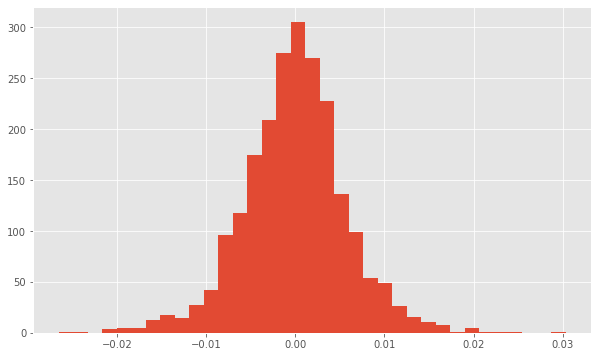

In [29]:
data.returns.hist(bins=35, figsize=(10,6));

create the features data by lagging the log returns and visual‐
izes it in combination with the returns data. 

In [30]:
lags = 2
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data.returns.shift(lag)
        cols.append(col)
    data.dropna(inplace=True)        

In [31]:
# Call the function
create_lags(data)

In [32]:
data.head()

,EUR,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544


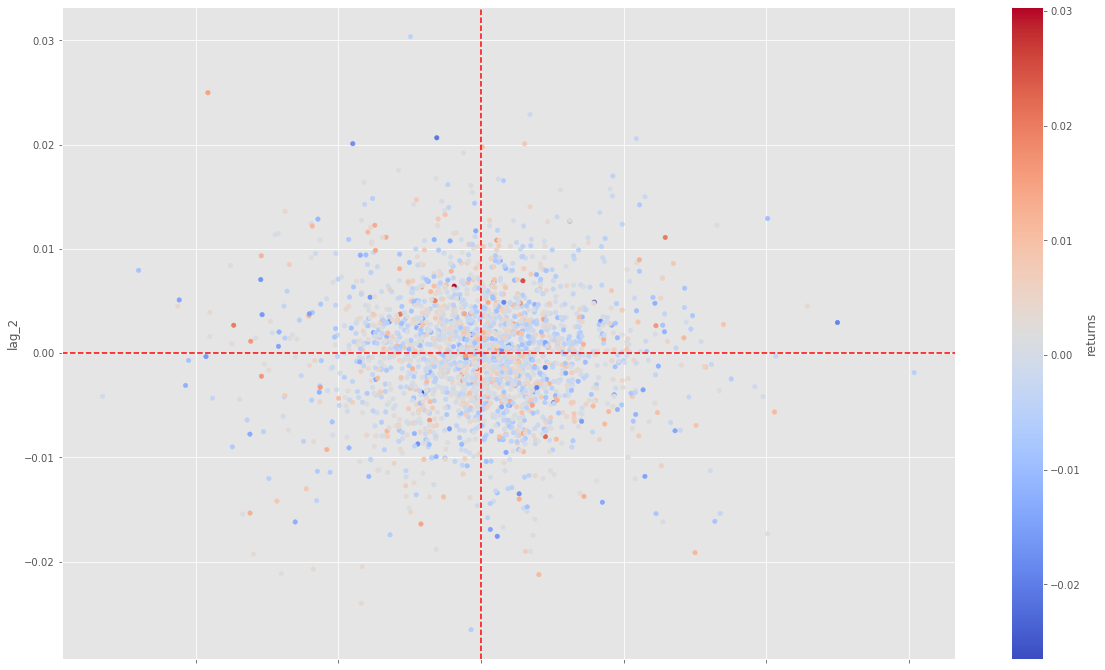

In [33]:
data.plot.scatter(x='lag_1', y='lag_2', c = 'returns', cmap='coolwarm', figsize=(20,12), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');

## Regression
 - With the data set completed, linear OLS regression can be applied to learn about any potential (linear) relationships, to predict market movement based on the features, and to backtest a trading strategy based on the predictions.

In [34]:
# OLS regression implementation from scikit-learn
from sklearn.linear_model import LinearRegression

D:\ProgramFiles\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [35]:
model = LinearRegression()

In [36]:
# the regression is implemented on the log returns directly
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])

In [37]:
# and on the direction data which is of primary interest.
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])

In [38]:
data[['pos_ols_1','pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-06,-0.000002,-0.000663
2010-01-07,-0.000164,0.001545
2010-01-08,0.000030,0.032971
2010-01-11,-0.000245,-0.004227
2010-01-12,-0.000154,-0.061068


In [39]:
# the real-valued predictions are transformed to directional values (+1, -1)
data[['pos_ols_1','pos_ols_2']] = np.where(data[['pos_ols_1','pos_ols_2']] > 0,1, -1 )

In [40]:
# two approaches yield different directional predictions in general
data['pos_ols_1'].value_counts().to_frame()

,pos_ols_1
-1,1863
1,350


In [41]:
data['pos_ols_2'].value_counts().to_frame()

,pos_ols_2
1,1310
-1,903


In [42]:
# both lead to a relatively large number of trades over time.
(data['pos_ols_1'].diff() != 0).sum()

653

In [43]:
(data['pos_ols_2'].diff() != 0).sum()

766

Equipped with the **directional prediction**, **vectorized backtesting** can be applied to **judge the performance** of the resulting **trading strategies**. 

In [44]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [45]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [46]:
data[['returns','strat_ols_1','strat_ols_2']].sum().apply(np.exp).head().to_frame(name="totals")

,totals
returns,0.813126
strat_ols_1,0.987177
strat_ols_2,1.287336


In [47]:
# Shows the number of correct and false predictions by the strategies.
(data['direction'] == data['pos_ols_1']).value_counts()

False    1132
True     1081
dtype: int64

In [48]:
(data['direction'] == data['pos_ols_2']).value_counts()

True     1145
False    1068
dtype: int64

### Performance of EUR/USD and regression-based strategies over time

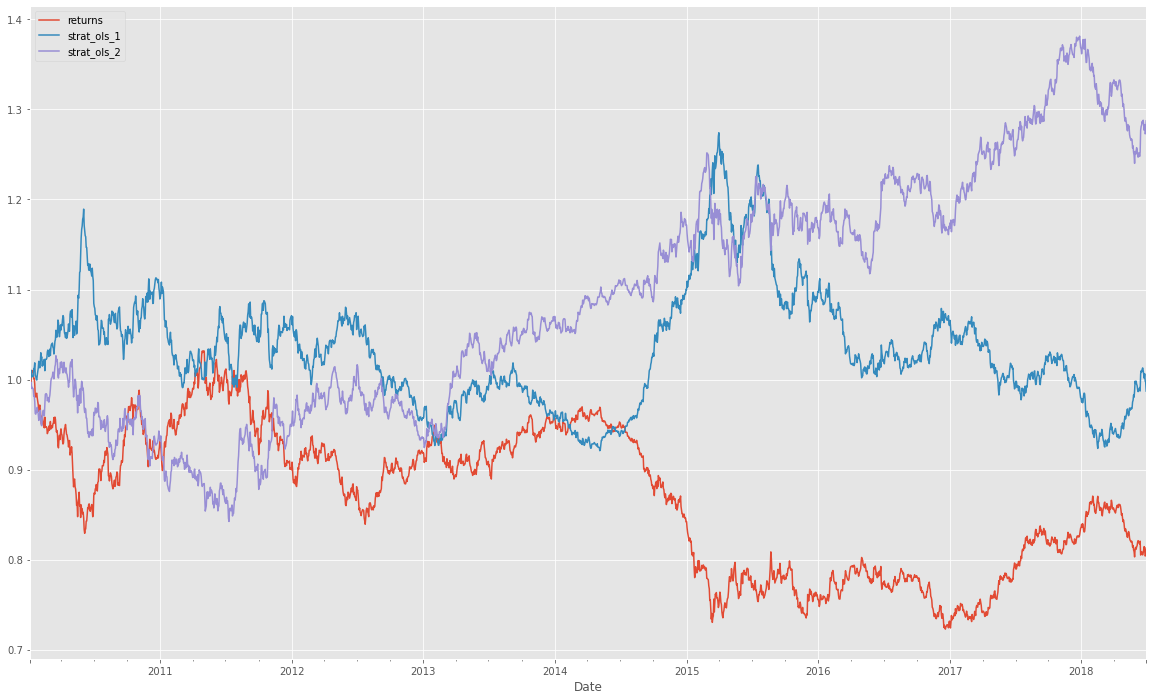

In [49]:
data[['returns','strat_ols_1','strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(20,12));

## References 

You find background information for the topics covered in this module in the following book:

* Hilpisch, Yves (2018): _Python for Finance_. 2nd ed., O'Reilly, chs. 6 & 15.

# End!